In [2]:
from dbConnect import con, cur
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def send_query(query) :
    cur.execute(query)
    return cur.fetchall()

In [3]:
import tqdm

query="""SELECT id FROM match_summary WHERE match_type= "official";"""
result = send_query(query)

queries = [
    "DELETE FROM position WHERE match_id = {};",
    "DELETE FROM attack WHERE match_id = {};",
    "DELETE FROM killv2 WHERE match_id = {};",
    "DELETE FROM take_damage WHERE match_id = {};",
    "DELETE FROM airplane WHERE match_id = {};",
    "DELETE FROM zone WHERE match_id = {};",
    "DELETE FROM participant WHERE match_id = {};",
    "DELETE FROM ride WHERE match_id = {};",
    "DELETE FROM throw WHERE match_id = {};",
    "DELETE FROM attachment WHERE match_id = {};",
    "DELETE FROM get_asset WHERE id= {};",
    "DELETE FROM match_summary WHERE id= {};",
]
for idx, i in tqdm.tqdm(enumerate(result)) :
    match_id= i[0]
    for query in queries:
        send_query(query.format(match_id))
    if idx%10==0 :
        con.commit()
con.commit()

5417it [1:47:25,  2.43s/it]

# 데이터 소개

## 경기 데이터 수와 집계된 유저 수

In [2]:
query = """
SELECT
    COUNT(DISTINCT(match_id))
FROM
    airplane
;"""
cur.execute(query)
query_result = cur.fetchall()
print(f"경기 데이터 수: \n    {query_result[0][0]:,}")

query = """
SELECT
    COUNT(id)
FROM
    user
;"""
cur.execute(query)
query_result = cur.fetchall()
print(f"집계된 유저 수:\n    {query_result[0][0]:,}")

경기 데이터 수: 
    19,365
집계된 유저 수:
    481,973


## 경쟁전 게임 수집된 경기 수

In [3]:
query= """
SELECT
    match_type,
    map_name,
    COUNT(match_id) AS amount
FROM
    match_summary
GROUP BY
    match_type, map_name 
WITH ROLLUP
ORDER BY
    GROUPING(match_type),
    match_type DESC, 
    amount ASC
;"""
cur.execute(query)
query_result = cur.fetchall()

for r in query_result :
    if r[0] is None and r[1] is None :
        print(f"총 계\n    {r[2]:,}")
    elif r[1] is None :
        print(f"{r[0]} 소 계\n    {r[2]:,}")
        print()
    else :
        print(f"{r[0]}, {r[1]}맵\n    {r[2]:,}")

official, Summerland_Main맵
    116
official, Desert_Main맵
    529
official, Chimera_Main맵
    544
official, Kiki_Main맵
    740
official, Neon_Main맵
    860
official, Baltic_Main맵
    2,788
official, Tiger_Main맵
    3,935
official, Savage_Main맵
    10,038
official 소 계
    19,550

competitive, Neon_Main맵
    899
competitive, DihorOtok_Main맵
    1,675
competitive, Tiger_Main맵
    1,894
competitive, Desert_Main맵
    2,176
competitive, Baltic_Main맵
    2,261
competitive 소 계
    8,905

총 계
    28,455


# 경쟁전 우승자 특징 알아보기
## 경쟁 우승팀의 평균 킬 수

In [4]:
query = """
SELECT
    `match_summary`.`map_name`,
    `match_summary`.`id`,
    COUNT(killv2.victim)
FROM
    `participant`
    INNER JOIN `match_summary` ON 
        `match_summary`.`id` = `participant`.`match_id`
        
    INNER JOIN `killv2` ON 
        `participant`.`match_id`= `killv2`.`match_id` AND 
        `participant`.`account_id`= `killv2`.`killer`
WHERE
    `participant`.`team_rank`= 1 AND
    `match_summary`.`match_type` = "competitive"
GROUP BY
    `match_summary`.`map_name`,
    `match_summary`.`id`
ORDER BY
    `match_summary`.`map_name` DESC
;"""
result = send_query(query)
df = pd.DataFrame(result, columns= ["map_name", "match", "kill_amount"])
type_dict = {
    "map_name": "string",
    "match": "int64",
    "kill_amount": "int32",
}
df = df.astype(type_dict)

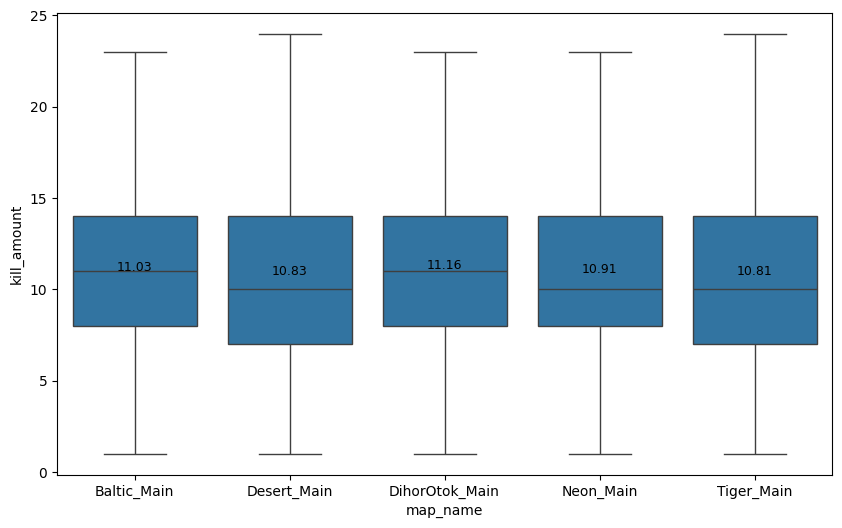

In [5]:
plt.figure(figsize=(10, 6))  # 가로 10인치, 세로 6인치
sns.boxplot(data=df,
            x="map_name", 
            y="kill_amount",
            order=df.sort_values(by="map_name")["map_name"].unique(),
            showfliers=False
            )
means= df.groupby(by="map_name")["kill_amount"].mean().to_list()
for i, mean in enumerate(means):
    plt.text(i, mean-0.2, f'{mean:.2f}', ha='center', va='bottom', color='black', fontsize=9)
plt.show()

## 경쟁전 우승자들이 사용하는 무기

In [6]:
query="""
SELECT
    `match_summary`.`map_name`,
    `killv2`.`killer_weapon_id`,
    COUNT(`killv2`.`victim`) AS `use_amount`
FROM
    `participant`
    INNER JOIN `match_summary` ON 
        `participant`.`match_id`= `match_summary`.`id`
    INNER JOIN `killv2` ON
        `participant`.`match_id`= `killv2`.`match_id` AND
        `participant`.`account_id`= `killv2`.`killer`
WHERE
    `participant`.`team_rank`= 1 AND
    `match_summary`.`match_type`= "competitive"
GROUP BY
    `match_summary`.`map_name`,
    `killv2`.`killer_weapon_id`
ORDER BY
    `match_summary`.`map_name` ASC,
    `use_amount` DESC
;"""
query_result= send_query(query)
df= pd.DataFrame(query_result, columns=["map_name", "weapon_id", "kill_amount"])
# 각 맵별 총 킬수
map_kill_amount_dict= df.groupby(by='map_name')['kill_amount'].sum().to_dict()
# 각 맵별 상위 10개 무기
top_kills = df.groupby('map_name').apply(lambda x: x.nlargest(10, 'kill_amount')).reset_index(drop=True)

# 상위 10개 무기 외 기타처리
sub_amount_dict= top_kills.groupby(by='map_name')['kill_amount'].sum().to_dict()
etc={key: map_kill_amount_dict[key]- sub_amount_dict[key] for key in map_kill_amount_dict.keys()}
for idx, key in enumerate(etc) :
    top_kills.loc[51+idx]= [key, 'etc', etc[key]]

그래프 보완할 것

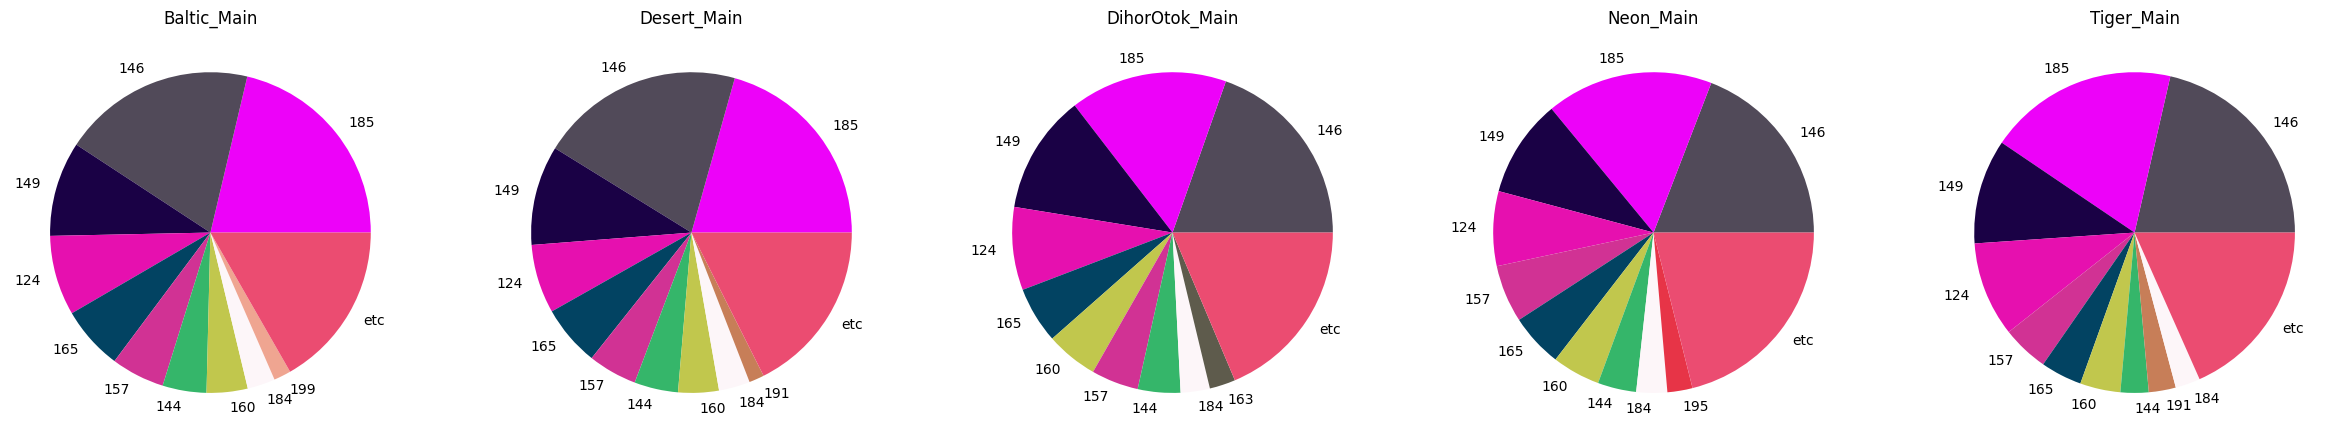

In [7]:
import random

# 색 생성
weapon_color_dict={}
for weapon in top_kills['weapon_id'].unique() :
    weapon_color_dict[weapon]= [random.random() for _ in range(3)]
# 서브플롯 생성 (2행 1열)
map_cnt=top_kills["map_name"].nunique()
fig, b = plt.subplots(1, map_cnt, figsize=(map_cnt*6, 6))

for idx, map_name in enumerate(list(top_kills["map_name"].unique())):
    map_colors=[weapon_color_dict[weapon] for weapon in top_kills[top_kills['map_name']== map_name]['weapon_id'].unique()]
    
    b[idx].pie(
        top_kills[top_kills["map_name"] == map_name]["kill_amount"],
        labels= top_kills[top_kills["map_name"] == map_name]["weapon_id"],
        colors=map_colors,
    )
    b[idx].set_title(f"{map_name}")
plt.show()

## 경쟁전 우승자들의 투척 무기 사용 횟수

In [8]:
query="""
SELECT
    `sub`.`map_name`,
    `weapon`.`weapon_name`,
    `sub`.`throw_amount`
FROM
    `weapon`
    INNER JOIN
    (SELECT
        `match_summary`.`map_name` AS `map_name`,
        `throw`.`weapon_id` AS `weapon_id`,
        COUNT(`throw`.`elapsed_time`) AS `throw_amount`
    FROM
        `participant`
        INNER JOIN `match_summary` ON 
            `participant`.`match_id` = `match_summary`.`id`
        INNER JOIN `throw` ON
            `participant`.`match_id` = `throw`.`match_id` AND
            `participant`.`account_id` = `throw`.`account_id`
    WHERE
        `participant`.`team_rank`= 1 AND
        `match_summary`.`match_type` = "competitive" AND
        `throw`.`weapon_id` !=84
    GROUP BY
        `match_summary`.`map_name`,
        `throw`.`match_id`,
        `throw`.`weapon_id`
    ORDER BY
        `map_name` ASC,
        `throw_amount` DESC) AS `sub` ON
    `weapon`.`id` = `sub`.`weapon_id`
;"""
cur.execute(query)
result= cur.fetchall()
df=pd.DataFrame(result, columns=["map_name", "weapon_id", "throw_amount"])

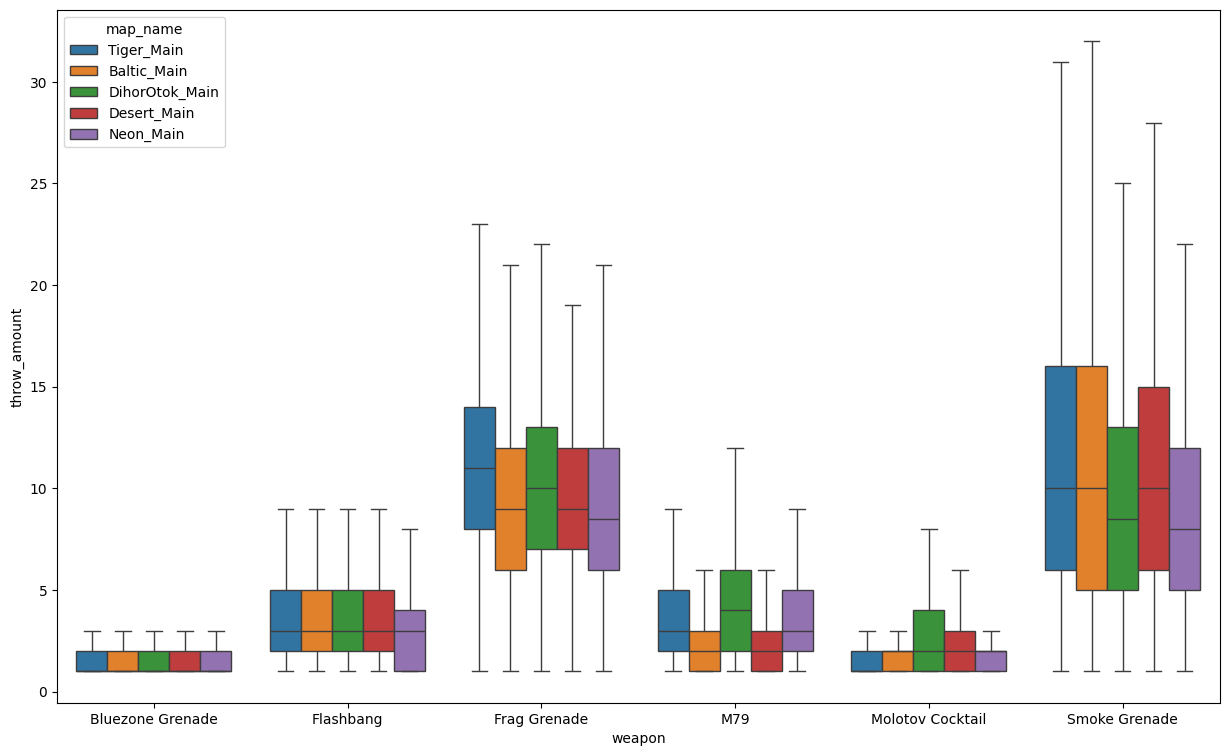

In [9]:
plt.figure(figsize=(15, 9))
sns.boxplot(data= df, 
            x="weapon_id", 
            y="throw_amount", 
            hue="map_name",
            showfliers=False,
            )
plt.xlabel('weapon')
plt.show()

## 경쟁전 우승팀의 팀원 생존률

In [10]:
query = """
SELECT
    `match_summary`.`map_name` AS `map_name`,
    `participant`.`match_id`,
    COUNT(`participant`.`account_id`) AS `total`,
    COUNT(`killv2`.`victim`) AS `die`
FROM
    `participant`
    INNER JOIN `match_summary` ON
        `participant`.`match_id` = `match_summary`.`id`
    LEFT JOIN `killv2` ON
        `participant`.`match_id` = `killv2`.`match_id` AND
        `participant`.`account_id` = `killv2`.`victim`
WHERE
    `participant`.`team_rank`= 1 AND
    `match_summary`.`match_type` = "competitive"
GROUP BY
    `participant`.`match_id`
ORDER BY
    `map_name` ASC
;"""
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result, columns = ["map_name", "match_id", "total", "die"])
df.loc[df["die"] == df["total"], "die"] = df.loc[df["die"] == df["total"], "die"] -1
df["alive_rate"] = (df['total']-df['die'])/df['total']

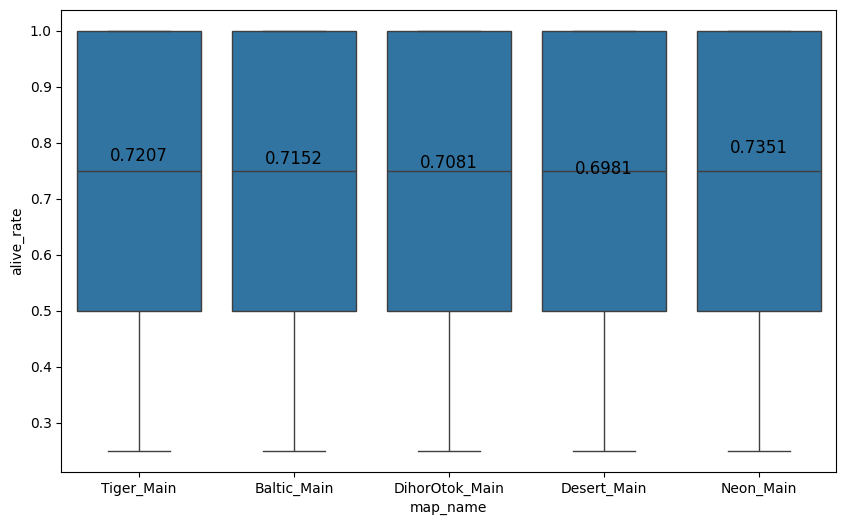

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data= df,
    x= "map_name",
    y="alive_rate",
)
means= df.groupby(by="map_name")["alive_rate"].mean().to_list()
for i, mean in enumerate(means):
    plt.text(i, mean+0.04, f'{mean:.4f}', ha='center', va='bottom', color='black', fontsize=12)
plt.show()

## 경쟁전 우승자들의 페이즈 별 킬 수

In [12]:
# 경기 별 페이즈 정보 불러오기
query = """
SELECT
    `zone`.`match_id`,
    `zone`.`phase`,
    `match_summary`.`map_name`,
    MAX(`zone`.`elapsed_time`)
FROM
    `zone`
    JOIN `match_summary` ON
        `match_summary`.`id`= `zone`.`match_id`
WHERE
    `match_summary`.`match_type`= "competitive"
GROUP BY
    `zone`.`match_id`, `zone`.`phase`
ORDER BY
    `zone`.`match_id` ASC,
    `zone`.`phase` ASC
;"""
result = send_query(query)
phase = pd.DataFrame(result, columns = ['match_id', 'phase', "map_name", 'end'])

# 경기 별 우승자들의 킬 불러오기
query = """
    SELECT
        `participant`.`match_id`,
        `participant`.`account_id`,
        `killv2`.`victim`,
        `killv2`.`elapsed_time`
    FROM
        `participant`
        JOIN `match_summary` ON
            `match_summary`.`id`= `participant`.`match_id`
        JOIN `killv2` ON
            `killv2`.`match_id`= `participant`.`match_id` AND
            `killv2`.`killer`= `participant`.`account_id`
    WHERE
        `participant`.`team_rank`= 1 AND
        `match_summary`.`match_type`= "competitive"
    ORDER BY
        `killv2`.`match_id` ASC,
        `killv2`.`elapsed_time` ASC
;"""
result = send_query(query)
killv2_df= pd.DataFrame(result, columns = ["match_id", "killer", "victim", "elapsed_time"])

# 킬 데이터에 페이즈 기입
killv2_df['phase'] = None

# 각 매치 구분
for match_id in phase['match_id'].unique() :
    phase_match_id_filter = phase['match_id'] == match_id
    killv2_match_id_filter = killv2_df['match_id'] == match_id
    phase_end_times = phase.loc[phase_match_id_filter, 'end'].to_list()
    # phase_start_times= [0, *phase_end_times[:-1]]
    def return_phase(elapsed_time) :
        for idx, end_time in enumerate(phase_end_times) :
            if elapsed_time<= end_time :
                return idx
        # 위 조건문에 해당하지 않을 경우 마지막 phase 리턴
        return idx
    killv2_df.loc[killv2_match_id_filter, 'phase']= killv2_df.loc[killv2_match_id_filter, 'elapsed_time'].apply(lambda x: return_phase(x))

merged = pd.merge(left=phase, right=killv2_df, how='left', on=['match_id', 'phase'])
winner_kill= pd.DataFrame(merged.groupby(by=["map_name",'match_id', 'phase'])['killer'].count()).reset_index()

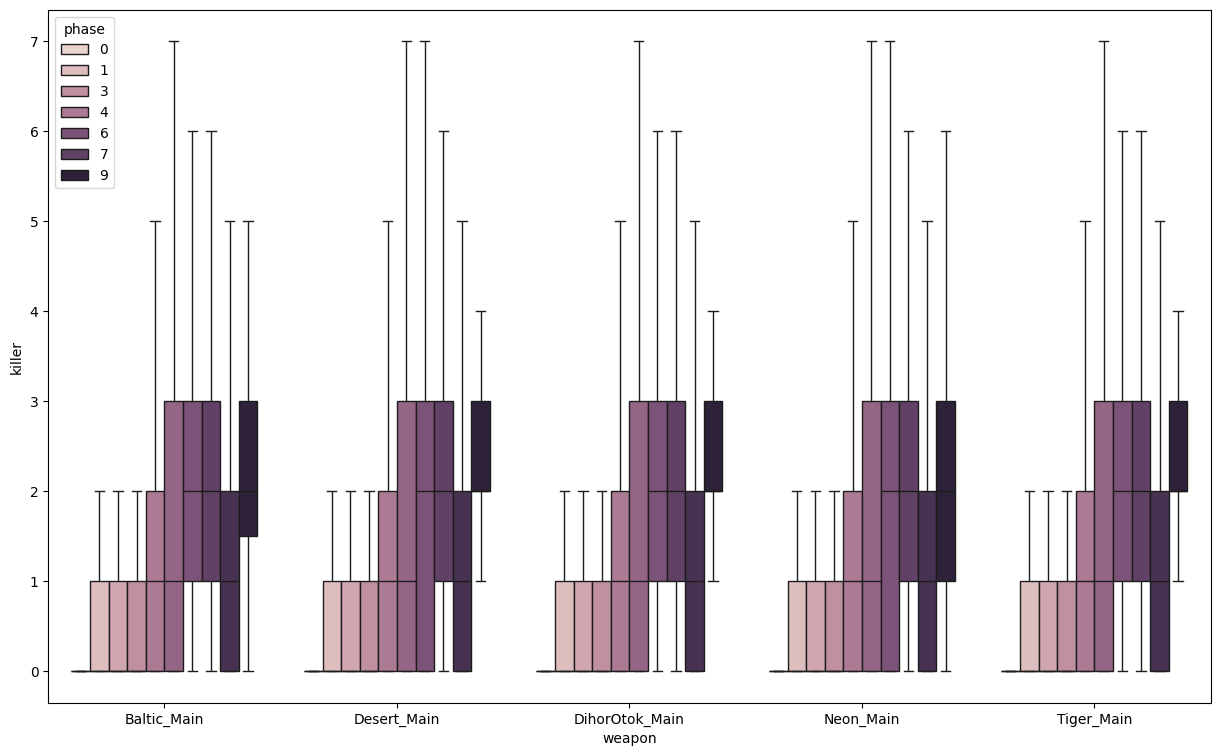

In [13]:
plt.figure(figsize=(15, 9))
sns.boxplot(data= winner_kill, 
            x="map_name", 
            y="killer", 
            hue="phase",
            showfliers=False,
            )
plt.xlabel('weapon')
plt.show()